<a href="https://colab.research.google.com/github/markwreinke/OrganStopClassifier/blob/main/PytorchAudio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This initially is me following the tutorial at https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html

It  will likely turn into my senior project

In [7]:
!pip install torchaudio # This allows me to run this in Google Colab
import torch
import torchaudio
import requests
import matplotlib.pyplot as plt

torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False
torchaudio.set_audio_backend("sox_io")

Shape of waveform: torch.Size([2, 276858])
Sample rate of waveform: 44100


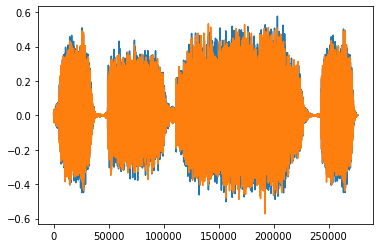

In [17]:
# This section is to open a file

#This gets a response object from an HTTP request
url = "https://pytorch.org/tutorials/_static/img/steam-train-whistle-daniel_simon-converted-from-mp3.wav"
r = requests.get(url)

# Opening the wav file (more likely creating a wav file) and writing the content
# from the above HTTP response content
with open('steam-train-whistle-daniel_simon-converted-from-mp3.wav', 'wb') as f:
  f.write(r.content)

# saves the file name of the above created wav file, loading and audio file from the
# given file into a tensor named 'waveform' and an int representing its namesake of
# 'sample_rate'
# The waveform is represented as a tensor of size [CxL] or [LxC] where 
# L is the # of audio frames and C is the number of channels
filename = "steam-train-whistle-daniel_simon-converted-from-mp3.wav"
waveform, sample_rate = torchaudio.load(filename)

# This shows that there are 2 channels in the wave file (left, right)
# and 276858 audio frames (a bit more than 6 seconds of audio at 44100 samples per second)
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

# A visual of the file's waveform
plt.figure()
plt.plot(waveform.t().numpy())

Shape of spectrogram: torch.Size([2, 201, 1385])


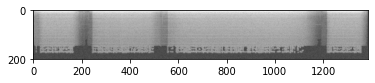

In [18]:
# look at the log of the spectrogram on a log scale
specgram = torchaudio.transforms.Spectrogram()(waveform) #This transforms the waveform into a spectrogram

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
plt.imshow(specgram.log2()[0,:,:].numpy(), cmap = 'gray')

/usr/local/lib/python3.6/dist-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


Shape of spectrogram: torch.Size([2, 128, 1385])


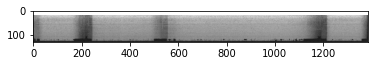

In [20]:
# Look at the Mel Spectrogram on a log scale

specgram = torchaudio.transforms.MelSpectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap = 'gray')

Shape of transformed waveform: torch.Size([1, 27686])


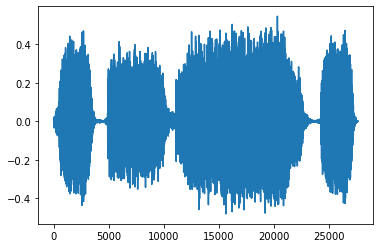

In [22]:
# Resample the waveform, one channel at a time

new_sample_rate = sample_rate/10

# Since resample applies to a single channel, we resample first channel here
channel = 0
transformed = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(waveform[channel, :].view(1,-1))

print("Shape of transformed waveform: {}".format(transformed.size()))

plt.figure()
plt.plot(transformed[0,:].numpy())